In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook determines batch size to be used for our problem - caps vs shoes.
Primary resource referenced is https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

1. Batch size is more for traning efficiency. Depends on how much you can fit in the memory
2. Some research is available stating that large batch sizes may cause learning to stuck in local minima and hence poor generalization
3. Batch size does not matter much after certain point as batch is just a sample for calculating gradient.

In this experiment, the maximum batch size is determined. Then some lesser batch sizes also tried out. The measurement is accuracy on test data, accuracy on randomly created out of set test and training stability.


##### Maximum batch size : Memory requirement of GPU

Nbytes, train = 4*(nparams*(2 + u) + m*(2a + d))

whereas for using the network at test time (after training), we require only
Nbytes, test = 4*(nparams + m*(a + d))

where:
• u is the size of the updater (u = 0 for SGD, u = 1 for Momentum, RMSProp, and Adagrad; u = 2 for Adam and Adadelta updaters)
• m is the mini-batch size
• a is the size of the network activations for a single example (all layers)
• d is the size of a single example

4 is count for array size, as a float32 value in ndarray takes 4 bytes

In [2]:
import os
import shutil
import time
import random
import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

from util.custom_callbacks import SkipLoggerCallback,LearningRateHistoryCallback

import matplotlib.pyplot as plt

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_decay_rate(train_size, batch_size_p = 32):
    MAX_EPOCHS = 3000
    iteration = int(train_size/batch_size_p)*MAX_EPOCHS
    learning_rate_start = 1e-2
    learning_rate_end = 1e-3
    decay = ((learning_rate_start/learning_rate_end) - 1)/iteration
    return decay

In [5]:
def define_model_architecture_64_32_16(sgd_optimizer = 'sgd'):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
#Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
# this is much simpler formula
memory_in_bytes = 3*1e+9
max_batch_size = memory_in_bytes/(4.0*(28*28*1 + 52882))
print(max_batch_size)

13975.328886073119


In [7]:
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(10):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [8]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

In [9]:
def get_generators_for_batch_size(batch_size_p = 32):
    test_img_generator = ImageDataGenerator( rescale = 1./255)
    train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                     horizontal_flip=True, fill_mode='nearest')

    train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical', batch_size=batch_size_p, subset='training')

    validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical', batch_size=batch_size_p, subset='validation')

    test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                      class_mode = 'categorical',batch_size=batch_size_p, shuffle=False)
    
    return train_batches,validation_batches,test_batches

In [10]:
batch_sizes = [32,64,128,256,512,1024]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 600

In [11]:
for batch_size in batch_sizes:
    print('working with batch size : %f' % batch_size)
    print('')
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    lr_history_callback = LearningRateHistoryCallback()
    callback_list = [lr_history_callback, tb_callback, skipLogger_callback]
    
    train_batches,validation_batches,test_batches = get_generators_for_batch_size(batch_size)
    
    #computed_decay = get_decay_rate(train_batches.samples, batch_size)
    #sgd = optimizers.SGD(lr=1e-2, decay=computed_decay)
    sgd = optimizers.SGD(lr=0.0066)
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/batch_size, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/batch_size, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
    training_time_dict[str(batch_size)] = time.time() - start
    learning_history_dict[str(batch_size)] = history
    out_of_set_test_dict[str(batch_size)] = get_oos_test_accuracy(model)
    lr_dict[str(batch_size)] = lr_history_callback
    
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))
    
    print('-'*120)

working with batch size : 32.000000

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


W0831 21:46:19.999120 140209243830080 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.679780    accuracy = 0.57    val_loss = 0.702147    val_accuracy = 0.60
epoch =   25    loss = 0.524327    accuracy = 0.75    val_loss = 0.549088    val_accuracy = 0.74
epoch =   50    loss = 0.501334    accuracy = 0.77    val_loss = 0.527913    val_accuracy = 0.79
epoch =   75    loss = 0.476763    accuracy = 0.78    val_loss = 0.595205    val_accuracy = 0.69
epoch =  100    loss = 0.471058    accuracy = 0.78    val_loss = 0.459381    val_accuracy = 0.81
epoch =  125    loss = 0.431299    accuracy = 0.82    val_loss = 0.455791    val_accuracy = 0.81
epoch =  150    loss = 0.424514    accuracy = 0.80    val_loss = 0.441557    val_accuracy = 0.82
epoch =  175    loss = 0.400099    accuracy = 0.82    val_loss = 0.445302    val_accuracy = 0.82
epoch =  200    loss = 0.394608    accuracy = 0.82    val_loss = 0.406193    val_accuracy = 0.82
epoch =  225    loss = 0.408057    accuracy = 0.82    val_loss = 0.474221    val_accuracy = 0.78
epoch =  250    loss = 0.38539

epoch =  550    loss = 0.400356    accuracy = 0.83    val_loss = 0.455314    val_accuracy = 0.82
epoch =  575    loss = 0.406042    accuracy = 0.82    val_loss = 0.467639    val_accuracy = 0.82
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Test loss: 0.4329 accuracy: 0.7638
------------------------------------------------------------------------------------------------------------------------
working with batch size : 256.000000

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.
epoch =    0    loss = 0.705759    accuracy = 0.50    val_loss = 0.782968    val_accurac

epoch =  325    loss = 0.553223    accuracy = 0.71    val_loss = 1.262379    val_accuracy = 0.72
epoch =  350    loss = 0.548838    accuracy = 0.73    val_loss = 1.273589    val_accuracy = 0.70
epoch =  375    loss = 0.561154    accuracy = 0.72    val_loss = 1.303724    val_accuracy = 0.68
epoch =  400    loss = 0.552796    accuracy = 0.73    val_loss = 1.288644    val_accuracy = 0.69
epoch =  425    loss = 0.552584    accuracy = 0.71    val_loss = 1.245656    val_accuracy = 0.70
epoch =  450    loss = 0.545451    accuracy = 0.73    val_loss = 1.255336    val_accuracy = 0.72
epoch =  475    loss = 0.542022    accuracy = 0.73    val_loss = 1.203546    val_accuracy = 0.75
epoch =  500    loss = 0.534579    accuracy = 0.74    val_loss = 1.252170    val_accuracy = 0.70
epoch =  525    loss = 0.536883    accuracy = 0.73    val_loss = 1.251040    val_accuracy = 0.71
epoch =  550    loss = 0.528364    accuracy = 0.76    val_loss = 1.231372    val_accuracy = 0.72
epoch =  575    loss = 0.54017

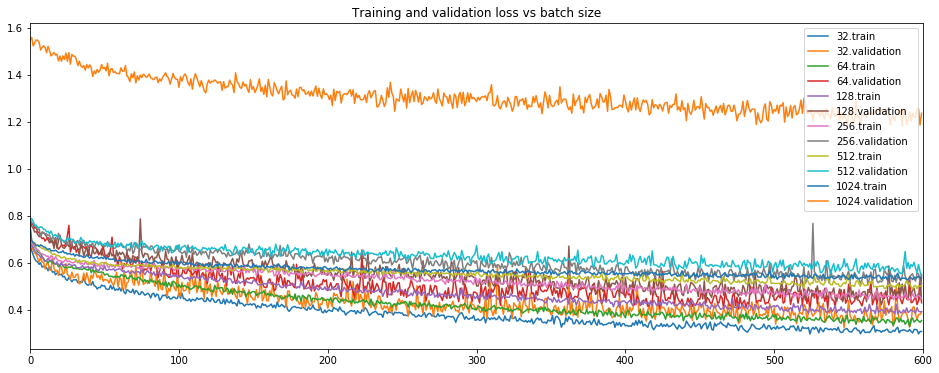

In [12]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

![Batch Size vs Accuracy](resources/images/batchsize_vs_accuracy.png)

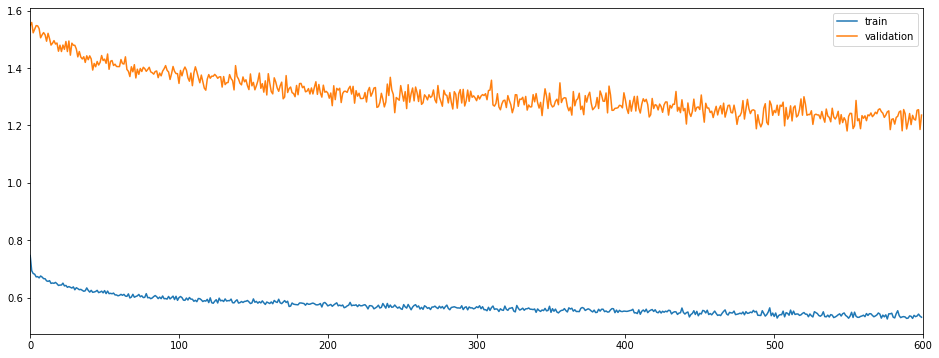

In [21]:
plt.figure(figsize=(16, 6))
plt.plot(learning_history_dict['1024'].history['loss'], label='train')
plt.plot(learning_history_dict['1024'].history['val_loss'], label='validation')
plt.legend()
plt.xlim(0, EPOCHS)
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(lr_dict['32'].lr, label='learning rate')
plt.xlabel("epochs")
plt.xlim(0, EPOCHS)
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

In [16]:
training_time_dict

{'32': 3411.9117703437805,
 '64': 3299.1927070617676,
 '128': 3380.4103260040283,
 '256': 3509.590718269348,
 '512': 3515.7615292072296,
 '1024': 4774.395740032196}

In [15]:
out_of_set_test_dict

{'32': (0.8566122, 0.045556232),
 '64': (0.85355103, 0.04163297),
 '128': (0.80734694, 0.035485327),
 '256': (0.82722443, 0.035315),
 '512': (0.7746531, 0.06976046),
 '1024': (0.7725153, 0.06932752)}

In [17]:
get_decay_rate(train_batches.samples, 256)

0.00042857142857142855

Observations:

1. batch size 32 and 64 are almost similar - similar loss curve. batch size 64 , loss stops dropping after iteration 475-500. 
2. larger batch sizes than 64 tend to overfit.